In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from collections import deque
import random
import gym
import glob

# シミュレーション条件
EPISODES_MAX = 200000 # エピソード
STEPS_MAX = 100
DT = 0.02  # 時間ステップ
THRESHOLD = 0.03
GOAL_POS = [0.0, 1.0]
THETA_INIT = 60 # [deg]
STEPS_INIT = 0

# 制御対象
L = 1.0  # アームの長さ
THETA_MAX = 180
THETA_MIN = 0


# 強化学習のパラメータ
ACTION_MIN = - 200 # [deg/s]
ACTION_MAX = 200 # [deg/s]
STATE_THETA_MAX = np.pi
STATE_THETA_MIN = 0.0
REWARD_G = 30
REWARD_P_JE = 0.0000000001
REWARD_P_V = 0.35
REWARD_P_T = 0.3
REWARD_STD_V = 1.0
REWARD_STD_T = 0.1
REWARD_STD_J = 10
TIME_PUNISH = 0.3
ALPHA = 0.1

# ニューラルネットワークのパラメータ
GAMMA = 0.99
GAMMA_P = 0.003
GAMMA_V = 0.01
RAYER_INPUT = 3
RAYER_OUTPUT_V = 1
RAYER_OUTPUT_M = 1
RAYER_OUTPUT_S = 1
RAYER_HIDDEN_1 = 64
RAYER_HIDDEN_2 = 64

# データ保存
SAVE_INTERVAL = 1000  # 1000エピソードごとに詳細データを保存

/Users/rikunishida114/2503-nishida-bachelor-thesis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


/var/folders/x8/_l05d3052hj6j9_4xhdyx9w00000gn/T/ipykernel_53258/1961147183.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


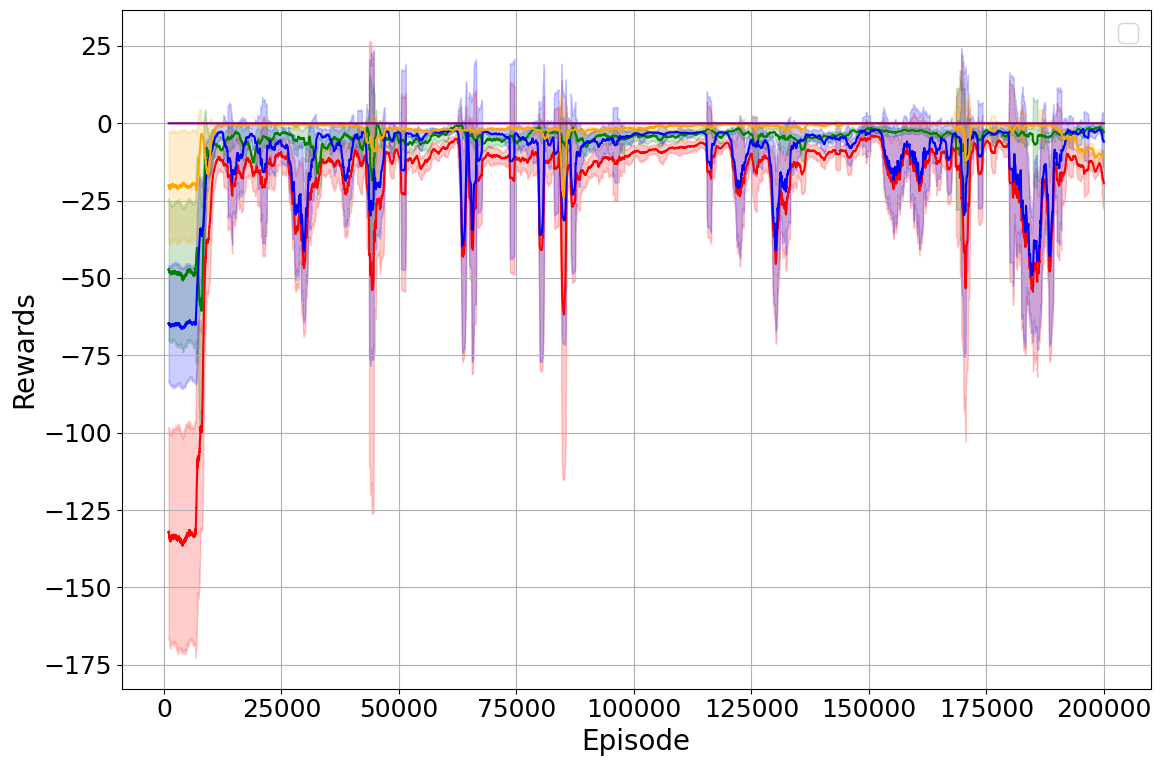

In [2]:
# 最新の報酬データを取得
reward_file = sorted(glob.glob("results/*_data_sum.csv"))[-1]  # 最新のファイルを選択
# reward_file = "results/2025-05-07_08-16-38_data_sum.csv"

# データを読み込む
data = pd.read_csv(reward_file, sep=" ", skiprows=1, header=None,
                   names=["Episode", "TotalReward", "RewardDist", "PenaltyJerk", "PenaltyVel", "PenaltyTime"])

# 10エピソードごとの平均と標準偏差を計算
window_size = 1000
for col in ["TotalReward", "RewardDist", "PenaltyJerk", "PenaltyVel", "PenaltyTime"]:
    data[f"{col}_Mean"] = data[col].rolling(window=window_size).mean()
    data[f"{col}_Std"] = data[col].rolling(window=window_size).std()

# プロット
plt.figure(figsize=(12, 8))

reward_components = [
    ("TotalReward", "Total Reward", "r"),
    ("RewardDist", "Distance Reward", "g"),
    ("PenaltyJerk", "Penalty (Jerk)", "b"),
    ("PenaltyVel", "Penalty (Velocity)", "orange"),
    ("PenaltyTime", "Penalty (Time)", "purple"),
]

for col, label, color in reward_components:
    plt.rcParams["font.size"] = 18
    plt.plot(data["Episode"], data[f"{col}_Mean"],  color=color)
    plt.fill_between(data["Episode"],
                     data[f"{col}_Mean"] - data[f"{col}_Std"],
                     data[f"{col}_Mean"] + data[f"{col}_Std"],
                     color=color, alpha=0.2)

plt.xlabel("Episode",fontsize=20)
plt.ylabel("Rewards",fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



/var/folders/x8/_l05d3052hj6j9_4xhdyx9w00000gn/T/ipykernel_53258/933455180.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


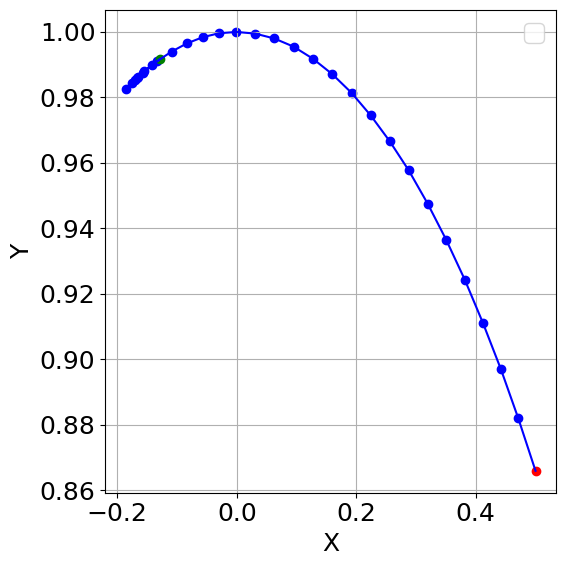

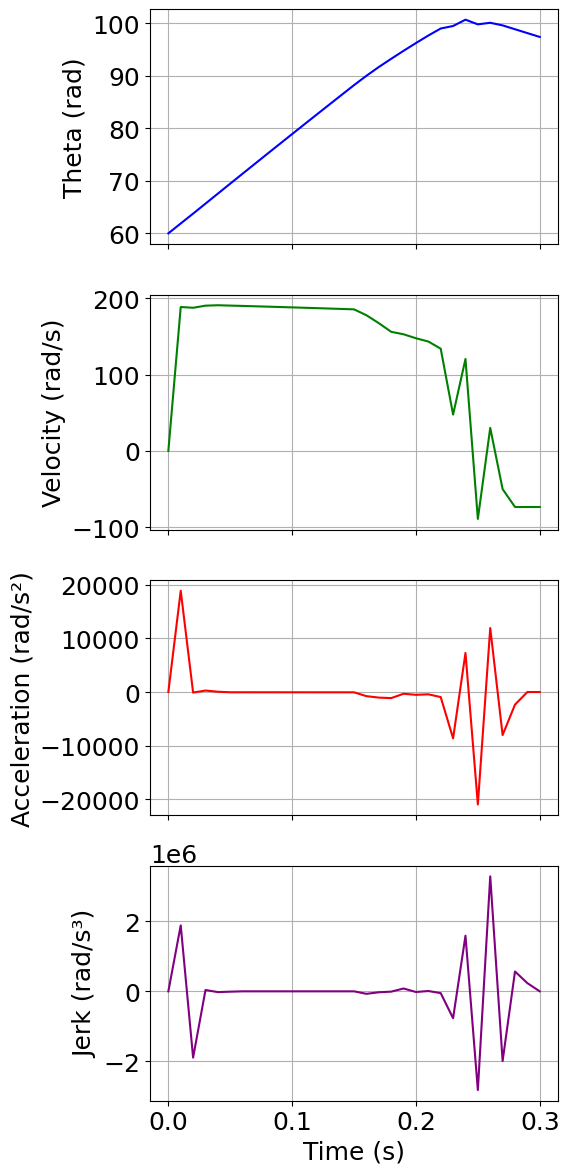

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# データファイル取得
data_files = sorted(glob.glob("results/*_eval_last_episode.csv"))
if not data_files:
    raise FileNotFoundError("2000エピソード目のデータが見つかりません。")

data_file = data_files[-1]  # 最新のファイルを選択
# data_file = "results/2025-05-07_08-16-38_data_200000.csv"

# データ読み込み
df = pd.read_csv(data_file, sep=" ", skiprows=1, header=None,
                 names=["Step", "Time", "HandX", "HandY", "Theta", "Theta_vel", "Theta_acc", "Theta_jer"])

# 保存用のベースファイル名
base_filename = os.path.splitext(os.path.basename(data_file))[0]

### ===== 1. 手先の軌道プロット ===== ###
fig1, ax1 = plt.subplots(figsize=(6, 6))

# 軌道全体（中間点のみ）を青でプロット
ax1.plot(df["HandX"], df["HandY"], linestyle="-", color="b")
ax1.scatter(df["HandX"].iloc[1:-1], df["HandY"].iloc[1:-1], color="b")  # 中間点のみ青

# 最初と最後の点を別色で強調
ax1.scatter(df["HandX"].iloc[0], df["HandY"].iloc[0], color="r")
ax1.scatter(df["HandX"].iloc[-1], df["HandY"].iloc[-1], color="g")

# 軸ラベル・凡例など
ax1.set_xlabel("X", fontsize=18)
ax1.set_ylabel("Y", fontsize=18)
ax1.legend()
ax1.grid()


plt.tight_layout()
plt.savefig(f"png/{base_filename}_trajectory.png", dpi=300)
plt.show()

### ===== 2. 間接の動的変数の変化 ===== ###
fig2, axes = plt.subplots(4, 1, figsize=(6, 12), sharex=True)
plt.rcParams["font.size"] = 15

# 関節角度
axes[0].plot(df["Time"], df["Theta"], color="blue")
axes[0].set_ylabel("Theta (rad)")
axes[0].grid()

# 関節角速度
axes[1].plot(df["Time"], df["Theta_vel"], color="green")
axes[1].set_ylabel("Velocity (rad/s)")
axes[1].grid()

# 関節角加速度
axes[2].plot(df["Time"], df["Theta_acc"], color="red")
axes[2].set_ylabel("Acceleration (rad/s²)")
axes[2].grid()

# 関節角躍度
axes[3].plot(df["Time"], df["Theta_jer"], color="purple")
axes[3].set_ylabel("Jerk (rad/s³)")
axes[3].set_xlabel("Time (s)")
axes[3].grid()

plt.tight_layout()
plt.savefig(f"png/{base_filename}_joint_dynamics.png", dpi=300)
plt.show()
